In [42]:
# Common imports
import pandas as pd
import numpy as np
import os
import math
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


import glob
import adjustText

import statsmodels
from statsmodels.stats.proportion import proportions_ztest


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [50]:
def z_test(sample_success_a, sample_size_a, sample_success_b, sample_size_b):
    '''takes sample_success_a, sample_size_a, sample_success_b, sample_size_b, returns p value from z test comparing two proportions'''

    significance = 0.05

    successes = np.array([sample_success_a, sample_success_b])
    samples = np.array([sample_size_a, sample_size_b])

    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    # report
    print('z_stat: %0.5f, p_value: %0.5f' % (stat, p_value))
    if p_value > significance:
        print ("Fail to reject the null hypothesis - we have nothing else to say")
    else:
        print ("Reject the null hypothesis - suggest the alternative hypothesis is true")
    return p_value

In [44]:
#list of WHO catalogue mutations associated with resistance to fluoroquinolones
cat_list=['gyrAG88A','gyrAG88C','gyrAA90V','gyrAS91P','gyrAD94A','gyrAD94G','gyrAD94H','gyrAD94N','gyrAD94Y', 
          'gyrBD461N', 'gyrBN499D', 'gyrBE501D', 'gyrBE501V', 'gyrBA504V']

In [45]:
#load data
features = pd.read_csv("ML_DATA_HIGHQ.csv")





In [47]:
#dicitonary of log2 ecoffs
ecoff_dict={'LEV': math.log2(2), 'MXF': math.log2(2)}

In [48]:
def MIC_distribution(df,drug,tag):
    '''takes a dataframe containg UNIQUEID and LOG2MIC columns, drug (either MXF or LEV) and a tag (string to use in saved graph)
        returns a histogram of MICs saved as *MIC_distribution'+drug+tag+'.png*'''
    drug_features=df.loc[df.DRUG==drug].sort_values('LOG2MIC', ascending=True).drop_duplicates(subset='UNIQUEID', keep="first")

    plt.figure()


    counts, bins, bars = plt.hist(drug_features['LOG2MIC'].astype('str'),bins=np.arange(drug_features.LOG2MIC.nunique()+0.5), color='grey', edgecolor='k')

    log2mic_unique=drug_features['LOG2MIC'].unique().tolist()
    ecoff=log2mic_unique.index(ecoff_dict[drug])

    plt.axvline(ecoff, color='r')
    no_r=0
    no_s=0
    for i in bins.tolist():
        
        
        index=bins.tolist().index(i)


        if i>=ecoff and i<bins.max():
            
 
            no_r=no_r+counts[index]


        
        if i<ecoff:
            no_s=no_s+counts[index]

            
    axes = plt.gca()

    y_min, y_max = axes.get_ylim()
    
    for pos in ['right', 'top']: 
        plt.gca().spines[pos].set_visible(False) 
    axes.tick_params(axis='both', which='major', labelsize=12)
    plt.text(log2mic_unique.index(ecoff_dict[drug])+1, y_max*0.9, 'R = '+str(int(no_r)), color='r', size=12, ha='left')
    plt.text(0+0.5, y_max*0.9, 'S = '+str(int(no_s)), color='b', size=12, ha='left')
    plt.xlabel('MIC', size=12)
    locs, labels = plt.xticks()
    new_locs=[]
    for i in locs:
        new_locs.append(i+0.5)
    if drug=='LEV':
        plt.xticks(new_locs, ['<=0.12','0.25','0.5','1','2','4','8', '>8'])
    elif drug=='MXF':
        plt.xticks(new_locs, ['<=0.06','0.12','0.25','0.5','1','2','4','>4'])
    plt.ylabel('Number of Isolates', size=12)
    plt.savefig('MIC_distribution'+drug+tag+'.png',dpi=300, transparent=True, bbox_inches='tight')
    

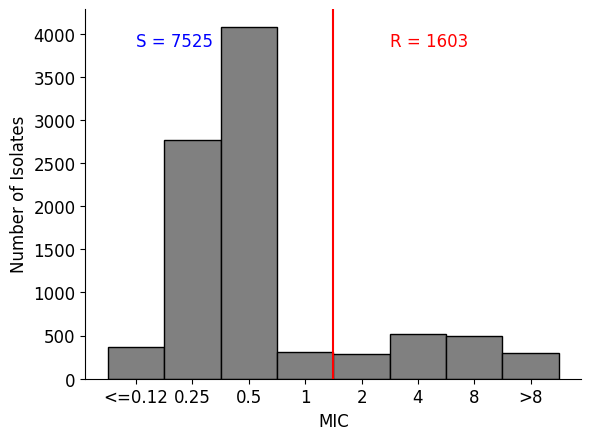

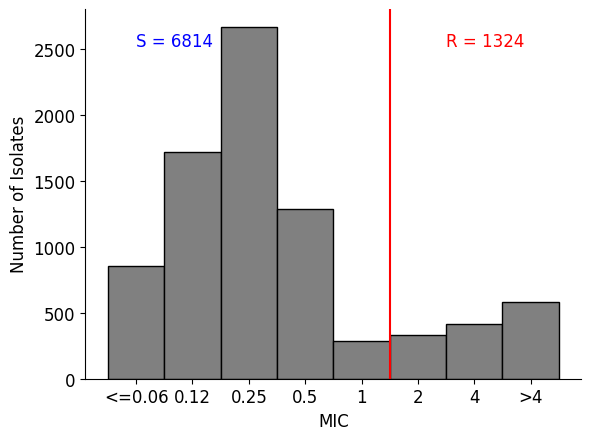

In [49]:
MIC_distribution(features,'LEV','ALL')
MIC_distribution(features,'MXF', 'ALL')

In [34]:
#catalogue performance on dataset
cat_performance_table= pd.DataFrame(columns=["Drug", "Total_R", "Total_S", "R_with_cat_muts", "S_with_cat_muts", "Hets_included"])

for i in ['LEV','MXF']:
    r_df=features.loc[(features.DRUG==i)&(features.BINARY_PHENOTYPE=='R')]
    s_df=features.loc[(features.DRUG==i)&(features.BINARY_PHENOTYPE=='S')]
    cat_performance_table=cat_performance_table.append({'Drug':i,
                                                       'Total_R': r_df.UNIQUEID.nunique(),
                                                       'Total_S': s_df.UNIQUEID.nunique(),
                                                       'R_with_cat_muts': r_df.loc[((r_df.GENEMUT.isin(cat_list))&(r_df.IS_HET==0))].UNIQUEID.nunique(),
                                                       'S_with_cat_muts': s_df.loc[((s_df.GENEMUT.isin(cat_list))&(s_df.IS_HET==0))].UNIQUEID.nunique(), 
                                                       'Hets_included': 'No'}, ignore_index=True)
cat_performance_table['Sensitivity']=cat_performance_table['R_with_cat_muts']/cat_performance_table['Total_R']*100
cat_performance_table['Specificity']=100-(cat_performance_table['S_with_cat_muts']/cat_performance_table['Total_S'])*100
cat_performance_table.to_csv('catalogue_performance.csv')
cat_performance_table

,Drug,Total_R,Total_S,R_with_cat_muts,S_with_cat_muts,Hets_included,Sensitivity,Specificity
0,LEV,1603,7525,1332,210,No,83.094198,97.209302
1,MXF,1324,6814,1131,410,No,85.422961,93.982976


In [35]:
#is there a significant difference in sensitivity of catalogue for levofloxacin and moxifloxacin? 
z_test(cat_performance_table.loc[cat_performance_table.Drug=='LEV'].R_with_cat_muts.to_list()[0], 
      cat_performance_table.loc[cat_performance_table.Drug=='LEV'].Total_R.to_list()[0], 
      cat_performance_table.loc[cat_performance_table.Drug=='MXF'].R_with_cat_muts.to_list()[0], 
      cat_performance_table.loc[cat_performance_table.Drug=='MXF'].Total_R.to_list()[0])

z_stat: -1.71694, p_value: 0.08599
Fail to reject the null hypothesis - we have nothing else to say


0.08598943414858128

In [36]:
#is there a significant difference in specificity of catalogue for levofloxacin and moxifloxacin? 
z_test(cat_performance_table.loc[cat_performance_table.Drug=='LEV'].Total_S.to_list()[0]-cat_performance_table.loc[cat_performance_table.Drug=='LEV'].S_with_cat_muts.to_list()[0], 
      cat_performance_table.loc[cat_performance_table.Drug=='LEV'].Total_S.to_list()[0], 
      cat_performance_table.loc[cat_performance_table.Drug=='MXF'].Total_S.to_list()[0]-cat_performance_table.loc[cat_performance_table.Drug=='MXF'].S_with_cat_muts.to_list()[0], 
      cat_performance_table.loc[cat_performance_table.Drug=='MXF'].Total_S.to_list()[0])

z_stat: 9.48560, p_value: 0.00000
Reject the null hypothesis - suggest the alternative hypothesis is true


2.4098601826138374e-21

In [37]:
#performance of catalogue when including FRS < 0.9

for i in ['LEV','MXF']:
    r_df=features.loc[(features.DRUG==i)&(features.BINARY_PHENOTYPE=='R')]
    s_df=features.loc[(features.DRUG==i)&(features.BINARY_PHENOTYPE=='S')]
    cat_performance_table=cat_performance_table.append({'Drug':i,
                                                       'Total_R': r_df.UNIQUEID.nunique(),
                                                       'Total_S': s_df.UNIQUEID.nunique(),
                                                       'R_with_cat_muts': r_df.loc[(r_df.GENEMUT.isin(cat_list))].UNIQUEID.nunique(),
                                                       'S_with_cat_muts': s_df.loc[(s_df.GENEMUT.isin(cat_list))].UNIQUEID.nunique(), 
                                                       'Hets_included': 'Yes'}, ignore_index=True)
cat_performance_table['Sensitivity']=cat_performance_table['R_with_cat_muts']/cat_performance_table['Total_R']*100
cat_performance_table['Specificity']=100-(cat_performance_table['S_with_cat_muts']/cat_performance_table['Total_S'])*100
cat_performance_table.to_csv('catalogue_performance_dp2.csv')
cat_performance_table

,Drug,Total_R,Total_S,R_with_cat_muts,S_with_cat_muts,Hets_included,Sensitivity,Specificity
0,LEV,1603,7525,1332,210,No,83.094198,97.209302
1,MXF,1324,6814,1131,410,No,85.422961,93.982976
2,LEV,1603,7525,1477,245,Yes,92.139738,96.744186
3,MXF,1324,6814,1245,463,Yes,94.033233,93.205166


In [38]:


def cat_performance_hets(measure):
    '''takes a measure in string formant e.g. 'Sensitivity' or 'Specificity', 
    returns a graph comparing performance of catalogue with and without FRS <0.9, needs cat_performance_table '''

    fig, ax = plt.subplots(figsize=(4,4))
    labels = ['LEV','MXF']
    no_hets=[]
    hets=[]
    z=[]
    if measure=='Sensitivity':
        
        for i in labels:
            no_hets.append(cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='No')].Sensitivity.to_list()[0])
            hets.append(cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='Yes')].Sensitivity.to_list()[0])
            
            z.append(z_test(cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='No')].R_with_cat_muts.to_list()[0],
                        cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='No')].Total_R.to_list()[0],
                        cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='Yes')].R_with_cat_muts.to_list()[0],
                        cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='Yes')].Total_R.to_list()[0]))
    elif measure=='Specificity':
    
        for i in labels:
            no_hets.append(cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='No')].Specificity.to_list()[0])
            hets.append(cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='Yes')].Specificity.to_list()[0])
   
    
            z.append(z_test(cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='No')].Total_S.to_list()[0]
                        - cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='No')].S_with_cat_muts.to_list()[0],
                        cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='No')].Total_S.to_list()[0],
                        cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='Yes')].Total_S.to_list()[0]
                        - cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='Yes')].S_with_cat_muts.to_list()[0],
                        cat_performance_table.loc[(cat_performance_table.Drug==i)&
                                                (cat_performance_table.Hets_included=='Yes')].Total_S.to_list()[0]))

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars
    

    #rects1 = ax.bar(x - width, FQ, width, label='Fluoroquinolone Resistant', color='#bc5090',edgecolor='k')
    rects2 = ax.bar(x - width/2, no_hets, width, label='FRS >= 0.9', color='white', edgecolor='black')
    rects3 = ax.bar(x + width/2, hets, width, label='No FRS cut off', color='gray',edgecolor='black')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(measure, size=12)
    ax.set_xticks(x)
    ax.set_ylim(0,100)
    ax.bar_label(rects2, fmt='%.1f', label_type='center')
    ax.bar_label(rects3, fmt='%.1f', label_type='center')
    
    plt.axhline(y=90, color='k', linestyle='--', linewidth=1)

    if z[0]<=0.05:
        plt.plot([x[0]-width/2, x[0]+width/2], [hets[0]+4, hets[0]+4],color="k")
        plt.plot([x[0]-width/2, x[0]-width/2], [no_hets[0]+2, hets[0]+4],color="k")
        plt.plot([x[0]+width/2, x[0]+width/2], [hets[0]+2, hets[0]+4],color="k")
    if z[1]<=0.05:
        plt.plot([x[1]-width/2, x[1]+width/2], [hets[1]+4, hets[1]+4],color="k")
        plt.plot([x[1]-width/2, x[1]-width/2], [no_hets[1]+2, hets[1]+4],color="k")
        plt.plot([x[1]+width/2, x[1]+width/2], [hets[1]+2, hets[1]+4],color="k")

    for pos in ['right', 'top']: 
        plt.gca().spines[pos].set_visible(False) 
    ax.set_xticklabels(labels)
    ax.legend(loc='lower right')
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.savefig('catalogue_performance_FRS10_'+measure+'.png',dpi=300, transparent=True, bbox_inches='tight')

z_stat: -7.77461, p_value: 0.00000
Reject the null hypothesis - suggest the alternative hypothesis is true
z_stat: -7.29720, p_value: 0.00000
Reject the null hypothesis - suggest the alternative hypothesis is true
z_stat: 1.66621, p_value: 0.09567
Fail to reject the null hypothesis - we have nothing else to say
z_stat: 1.85415, p_value: 0.06372
Fail to reject the null hypothesis - we have nothing else to say


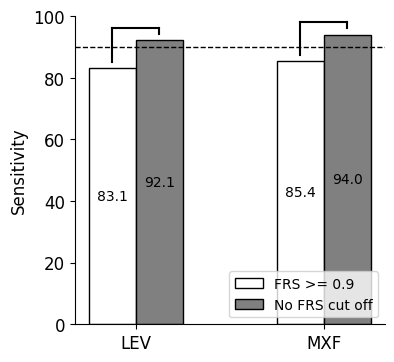

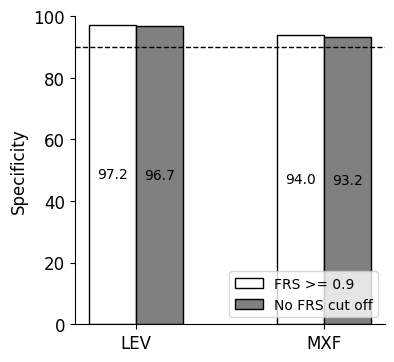

In [39]:
#create graphs comparing catalogue performance when including FRS < 0.9
cat_performance_hets('Sensitivity')
cat_performance_hets('Specificity')

In [40]:
#number of levofloxacin resistant isolates not predicted by catalogue and number of dna gyrase mutations they have
lev_tp=features.loc[(features.DRUG=='LEV')&(features.BINARY_PHENOTYPE=='R')&(features.GENEMUT.isin(cat_list))].UNIQUEID.to_list()
lev_fn_df=features.loc[(features.DRUG=='LEV')&(features.BINARY_PHENOTYPE=='R')&(-features.UNIQUEID.isin(lev_tp))]

print('FALSE NEGATIVES: ', lev_fn_df.UNIQUEID.nunique())
print('of which have 0 DNA gyrase mutations: ',lev_fn_df.loc[lev_fn_df.NUMBER_OF_MUTATIONS==0].UNIQUEID.nunique())
print('of which have 1 DNA gyrase mutation: ',lev_fn_df.loc[lev_fn_df.NUMBER_OF_MUTATIONS==1].UNIQUEID.nunique())
print('of which have 2 or more DNA gyrase mutations: ',lev_fn_df.loc[lev_fn_df.NUMBER_OF_MUTATIONS>=2].UNIQUEID.nunique())

#list dna gyrase mutations
lev_fn_df.GENEMUT.unique()

lev_fn_df.to_csv('FN_FEATURES_LEV.csv', index=False)

FALSE NEGATIVES:  126
of which have 0 DNA gyrase mutations:  84
of which have 1 DNA gyrase mutation:  33
of which have 2 or more DNA gyrase mutations:  9


In [41]:
#number of moxifloxacin resistant isolates not predicted by catalogue and number of dna gyrase mutations they have
mxf_tp=features.loc[(features.DRUG=='MXF')&(features.BINARY_PHENOTYPE=='R')&(features.GENEMUT.isin(cat_list))].UNIQUEID.to_list()
mxf_fn_df=features.loc[(features.DRUG=='MXF')&(features.BINARY_PHENOTYPE=='R')&(-features.UNIQUEID.isin(mxf_tp))]

print('FALSE NEGATIVES: ', mxf_fn_df.UNIQUEID.nunique())
print('of which have 0 DNA gyrase mutations: ',mxf_fn_df.loc[mxf_fn_df.NUMBER_OF_MUTATIONS==0].UNIQUEID.nunique())
print('of which have 1 DNA gyrase mutation: ',mxf_fn_df.loc[mxf_fn_df.NUMBER_OF_MUTATIONS==1].UNIQUEID.nunique())
print('of which have 2 or more DNA gyrase mutations: ',mxf_fn_df.loc[mxf_fn_df.NUMBER_OF_MUTATIONS>=2].UNIQUEID.nunique())

#list dna gyrase mutations
mxf_fn_df.GENEMUT.unique()

mxf_fn_df.to_csv('FN_FEATURES_MXF.csv', index=False)

FALSE NEGATIVES:  79
of which have 0 DNA gyrase mutations:  51
of which have 1 DNA gyrase mutation:  22
of which have 2 or more DNA gyrase mutations:  6
